<a href="https://colab.research.google.com/github/ykitaguchi77/CongenitalGlaucoma_AI_project/blob/main/Periocular_annotations_for_YOLOv5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Periocular_annotations_for_YOLOv5**

In [87]:
import pandas as pd
import os
import glob
import shutil
import glob
import random
from PIL import Image
import time
%matplotlib inline

#サポートパッチのインポート
from google.colab.patches import cv2_imshow
import cv2


# Google Driveをマウント
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import pandas as pd

# 患者のリスト
csv_path = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_dataset_for_YOLOv5/patient_data.csv"

df = pd.read_csv(csv_path, index_col= 0)
df

,id,R,L
0,1546,0,1
1,1962,1,1
2,2004,1,0
3,2223,1,0
4,2761,0,1
5,3229,1,0
6,3422,1,1
7,379,1,1
8,4377,1,0
9,4407,1,0


In [ ]:
# glaucoma_extended datasetをcolab上に解凍する
!cp "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/glaucoma_extended_dataset.zip" .
!unzip glaucoma_extended_dataset.zip



#**Extract periocular images and annotate with dataframe**

## Haarcascadeを指定

In [18]:
# カスケードファイルのパス
eye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_eye.xml'
# righteye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_righteye_2splits.xml'
# lefteye_cascade_path = '/content/drive/My Drive/Deep_learning/haarcascade_lefteye_2splits.xml'


# カスケード分類器の特徴量取得
eye_cascade = cv2.CascadeClassifier(eye_cascade_path)
# righteye_cascade = cv2.CascadeClassifier(eye_cascade_path)
# lefteye_cascade = cv2.CascadeClassifier(eye_cascade_path)

In [20]:
#アスペクト比を維持したまま横を400pixelに縮小する
def scale_to_width(img, width):
    scale = width / img.shape[1]
    return cv2.resize(img, dsize=None, fx=scale, fy=scale)

#図を表示する
def show_image(img):
    #img = cv2.imread(out_path)
    dst = scale_to_width(img, 200)
    cv2_imshow(dst)

# def show_image_pillow(img):
#     src = cv2.cvtColor(img_resized_list[0], cv2.COLOR_BGR2RGB)
#     plt.imshow(src)

def my_round(val, digit=0):
    p = 10 ** digit
    return int((val * p * 2 + 1) // 2 / p)

def scale_to_width(img, width):
    """幅が指定した値になるように、アスペクト比を固定して、リサイズする。
    """
    h, w = img.shape[:2]
    height = round(h * (width / w))
    dst = cv2.resize(img, dsize=(width, height))

    return dst

## 眼周囲切り抜き

class_num = 4



0: 右眼、濁りなし

1: 右眼、濁りあり

2: 左眼、濁りなし

3: 左眼、濁りあり

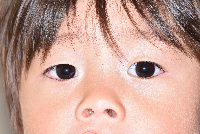


image path =  /content/dataset_extended/9448-20190925-2-120020_03b29d4c2c987347885031b9d34db8d3a69a0d672f678e206f1b6fbaecaa811b.jpg
目が4個検出されました
eye_list: [[1873  716  649  649]
 [ 578  731  683  683]
 [1119 1508  342  342]
 [1460 1484  379  379]]


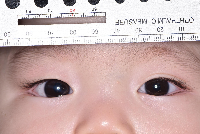


image path =  /content/dataset_extended/8500-20200827-1-135549_c4b039e70ae701c2f8edf78ee98152d7f1030f2610cd58c18fb6f7bf7b6c63a2.jpg
目が2個検出されました
eye_list: [[1914  812  925  925]
 [ 252  833  954  954]]
[ex,ey] = 1914,812 [ew,eh] = 925,925


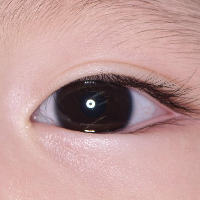

left: 1914, right: 2839, img_width: 2992
class_num: 2
[ex,ey] = 252,833 [ew,eh] = 954,954


In [ ]:
orig_folder = "/content/dataset_extended"
dst_folder = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_dataset_for_YOLOv5/images"
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
os.makedirs(dst_folder)


path_list = glob.glob(orig_folder+"/*")
#path_list = [path_list[1]] #テスト用
dst_folder = dst_folder

#処理時間の計測
start = time.time()

#もしdst_folderがあれば削除して新しく作り直す
if os.path.exists(dst_folder):
    shutil.rmtree(dst_folder)
os.makedirs(f"{dst_folder}/images") #image格納用
os.makedirs(f"{dst_folder}/images_cropped") #cropped_image格納用 (YOLOでは使用しない)
os.makedirs(f"{dst_folder}/labels") #label格納用


num=0
showImage = True
for path in path_list:
    try: #目が検出されなかった場合のエラー回避。片目ずつ抜き出して保存
        img2 = cv2.imread(path).copy()

        img_resized_list,side_list = [],[]

        img = cv2.imread(path) 
        img2 = img.copy()

        if showImage:
            show_image(img)

        # 画像グレースケール化
        grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        #300pix以上のもので目に見えるものを抽出
        eye_list = eye_cascade.detectMultiScale(grayscale_img, minSize=(300, 300))
        print("")
        print('image path = ', path)

        # 眼検出判定
        if len(eye_list) >= 1:
            print('目が' + str(len(eye_list)) +'個検出されました')
            pass
        else:
            print("no eye detected")
            pass

        print(f"eye_list: {eye_list}")

        #画像の切り抜きと保存（連番にする）
        if len(eye_list)== 2: 
            
            for (ex, ey, ew, eh) in eye_list:
                print("[ex,ey] = %d,%d [ew,eh] = %d,%d" %(ex, ey, ew, eh))
 
                cv2.rectangle(img2, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

                #切り抜き範囲が元画像をはみ出る場合は黒画像で埋める
                top = max(0, int(ey))
                bottom = min(grayscale_img.shape[0], int(ey + eh))
                left = max(0, int(ex))
                right = min(grayscale_img.shape[1], int(ex + ew))

                #print(f"top:{top}, bottom:{bottom}, left:{left}, right:{right}")

                img_cropped = img[top: bottom,left:right]
                height, width = img_cropped.shape[:2]

                #クロップした画像を表示
                if showImage:
                    show_image(img_cropped)

                print(f"left: {left}, right: {right}, img_width: {img.shape[1]}")

                #右か左かの判定
                if left >= img.shape[1]/2:
                    laterality = "L"
                elif right <= img.shape[1]/2:
                    laterality = "R"

                #混濁の有無（dfより抽出）
                id = os.path.basename(path).split("-")[0]

                if laterality == "R":
                    if df.loc[df['id'] == int(id), "R"].values[0] == 0:
                        class_num = 0 #右眼かつ混濁あり
                    elif df.loc[df['id'] == int(id), "R"].values[0] == 1:
                        class_num = 1 #右眼かつ混濁あり
                elif laterality == "L":
                    if df.loc[df['id'] == int(id), "L"].values[0] == 0:
                        class_num = 2 #左眼かつ混濁なし
                    elif df.loc[df['id'] == int(id), "L"].values[0] == 1:
                        class_num = 3 #左眼かつ混濁あり

                print(f"class_num: {class_num}")

                #縦、横に対する割合
                X = round((right+left)/2/img2.shape[1], 6)
                Y = round((top+bottom)/2/img2.shape[0], 6)
                W = round((right-left)/img.shape[1], 6)
                H = round((bottom-top)/img.shape[0], 6)
                txt = f"{class_num} {X} {Y} {W} {H}"

                img2 = scale_to_width(img2, 640)  #切り抜く前の画像を横のサイズを640になるように縮小
                cv2.imwrite(f"{dst_folder}/images/{os.path.basename(path).split('.')[0]}.JPG", img) #cropせずに縮小したイメージを保存
                cv2.imwrite(f"{dst_folder}/images_cropped/{os.path.basename(path).split('.')[0]}_{laterality}.JPG", img_cropped) #cropしたイメージを保存する場合

                with open(f"{dst_folder}/labels/{os.path.basename(path).split('.')[0]}.txt", mode='a') as f:
                    f.write(f"{txt}\n")
                num+=1
    except:
        pass

print("")
print('Process done!!')
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")
print (f"image_num:{num}")

In [84]:
def crop_bilateral(in_path, df, size, showImage=True):
    img_resized_list,side_list = [],[]

    img = cv2.imread(in_path) 
    img2 = img.copy()

    if showImage:
        show_image(img)

    # 画像グレースケール化
    grayscale_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    #300pix以上のもので目に見えるものを抽出
    eye_list = eye_cascade.detectMultiScale(grayscale_img, minSize=(300, 300))
    print("")
    print('image path = ',in_path)

    # 眼検出判定
    if len(eye_list) >= 1:
        print('目が' + str(len(eye_list)) +'個検出されました')
        pass
    else:
        print("no eye detected")
        pass

    print(f"eye_list: {eye_list}")

    #画像の切り抜きと保存（連番にする）
    if len(eye_list)== 2: 

        
        for (ex, ey, ew, eh) in eye_list:
            print("[ex,ey] = %d,%d [ew,eh] = %d,%d" %(ex, ey, ew, eh))
            
            try:
                cv2.rectangle(img2, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

                #切り抜き範囲が元画像をはみ出る場合は黒画像で埋める
                top = max(0, int(ey))
                bottom = min(grayscale_img.shape[0], int(ey + eh))
                left = max(0, int(ex))
                right = min(grayscale_img.shape[1], int(ex + ew))

                #print(f"top:{top}, bottom:{bottom}, left:{left}, right:{right}")

                img_cropped = img[top: bottom,left:right]
                height, width = img_cropped.shape[:2]

                #クロップした画像を表示
                if showImage:
                    show_image(img_cropped)

                print(f"left: {left}, right: {right}, img_width: {img.shape[1]}")

                #右か左かの判定
                if left >= img.shape[1]/2:
                    laterality = "L"
                elif right <= img.shape[1]/2:
                    laterality = "R"

                #混濁の有無（dfより抽出）
                id = os.path.basename(in_path).split("-")[0]

                print(f"laterality: {laterality}, id: {id}")

                

                if laterality == "R":
                    if df.loc[df['id'] == int(id), "R"].values[0] == 0:
                        class_num = 0 #右眼かつ混濁あり
                    elif df.loc[df['id'] == int(id), "R"].values[0] == 1:
                        class_num = 1 #右眼かつ混濁あり
                elif laterality == "L":
                    if df.loc[df['id'] == int(id), "L"].values[0] == 0:
                        class_num = 2 #左眼かつ混濁なし
                    elif df.loc[df['id'] == int(id), "L"].values[0] == 1:
                        class_num = 3 #左眼かつ混濁あり

                print(f"class_num: {class_num}")

                #縦、横に対する割合
                X = round((right+left)/2/img2.shape[1], 6)
                Y = round((top+bottom)/2/img2.shape[0], 6)
                W = round((right-left)/img.shape[1], 6)
                H = round((bottom-top)/img.shape[0], 6)
                txt = f"{class_num} {X} {Y} {W} {H}"
                
                if laterality == "R":
                    return img_cropped, f"{class_num} {X} {Y} {W} {H}"
                elif laterality == "L":
                    return img_cropped, f"{class_num} {X} {Y} {W} {H}"


            except: 
                pass

        
        # ex = min(eye_list[0][0], eye_list[1][0])
        # ey = min(eye_list[0][1], eye_list[1][1])
        # ew = max(eye_list[0][0]+eye_list[0][2], eye_list[1][0]+eye_list[1][2]) - ex
        # eh = max(eye_list[0][1]+eye_list[0][3], eye_list[1][1]+eye_list[1][3]) - ey

        # print("[ex,ey] = %d,%d [ew,eh] = %d,%d" %(ex, ey, ew, eh))

        # try:
        #     cv2.rectangle(img2, (ex, ey), (ex + ew, ey + eh), (0, 255, 0), 2)

        #     #切り抜き範囲が元画像をはみ出る場合は黒画像で埋める
        #     top = max(0, int(ey-eh/4))
        #     bottom = min(grayscale_img.shape[0], int(ey+7/6*eh))
        #     left = max(0,int(ex-ew/10))
        #     right = min(grayscale_img.shape[1], int(ex + 11/10*ew))

        #     print(f"top:{top}, bottom:{bottom}, left:{left}, right:{right}")

        #     img_cropped = img[top: bottom,left:right]
        #     height, width = img_cropped.shape[:2]

        #     img_resized = scale_to_width(img_cropped, size) #1辺を指定したpixにresize 

        #     #クロップした画像を表示
        #     if showImage:
        #         show_image(img_resized)
        #     print(img2.shape)

        #     #縦、横に対する割合
        #     X = round((right+left)/2/img2.shape[1], 6)
        #     Y = round((top+bottom)/2/img2.shape[0], 6)
        #     W = round((right-left)/img.shape[1], 6)
        #     H = round((bottom-top)/img.shape[0], 6)
        #     txt = f"{class_num} {X} {Y} {W} {H}"
        #     return img_resized, txt

        # except:
        #     print('crop error')


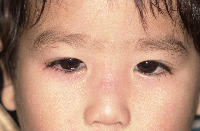


image path =  /content/dataset_extended/3422-20061031-6-123332_a3093fe1bc0e5f7fa26f11b63b9350b8174cc08a9cf56f70c7fad667c2f17f05.jpg
目が2個検出されました
eye_list: [[1244  436  477  477]
 [ 388  394  527  527]]
[ex,ey] = 1244,436 [ew,eh] = 477,477


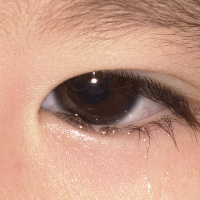

left: 1244, right: 1721, img_width: 2000
laterality: L, id: 3422
class_num: 3
3 0.74125 0.514101 0.2385 0.363567


In [86]:
test_path = glob.glob(f"/content/dataset_extended/*")[1]
img, txt = crop_bilateral(test_path, df,  size=640)
print(txt)

with open("test.txt", mode='w') as f:
    f.write(txt)


In [ ]:
#glaucoma患者のリストを作成
image_dir = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/dataset_for_YOLO_1280px"


gla_folder = ["gla_eso", "gla_exo", "gla_ortho"]

patient_id_list = []
for folder in gla_folder:
    file_list = [os.path.basename(i).split('-')[0].split('_')[0] for i in glob.glob(f"{image_dir}/{folder}/*")]
    patient_id_list.extend(file_list)

patient_id_list = sorted(list(set(patient_id_list)))
print(patient_id_list)
len(patient_id_list)


['1546', '1962', '2004', '2223', '2761', '3229', '3422', '379', '4377', '4407', '4725', '4849', '5393', '5617', '5821', '6668', '6821', '6895', '713', '7154', '7495', '781', '8126', '8128', '8193', '8246', '8294', '8425', '8492', '8500', '8698', '8882', '8921', '9056', '9201']


35

In [ ]:
df_patient_data = pd.DataFrame(index=[], columns=[])
df_patient_data["id"] = patient_id_list
df_patient_data

In [ ]:
#patient_idの入った空のリストをセーブ

new_dir = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_dataset_for_YOLOv5"
if os.path.exists(new_dir):
    shutil.rmtree(new_dir)
os.makedirs(new_dir)

df_patient_data.to_csv(f"{new_dir}/patient_data_vacant.csv")


idの横にRとLの列を作成

混濁していたら1を記入

patient_data.csvとして保存

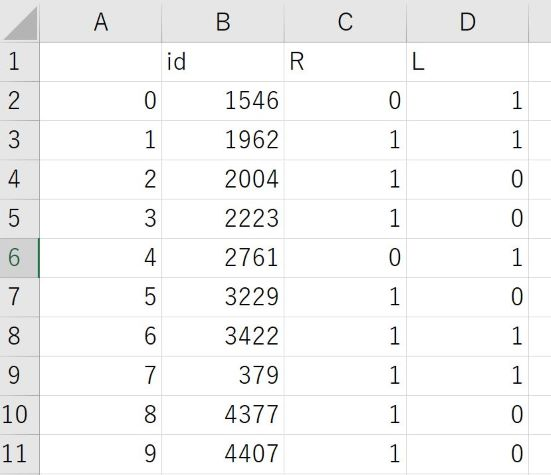

In [ ]:
import pandas as pd

csv_path = "/content/drive/MyDrive/Deep_learning/Congenital_Glaucoma/extended_dataset_for_YOLOv5/patient_data.csv"

df = pd.read_csv(csv_path, index_col= 0)
df



,id,R,L
0,1546,0,1
1,1962,1,1
2,2004,1,0
3,2223,1,0
4,2761,0,1
5,3229,1,0
6,3422,1,1
7,379,1,1
8,4377,1,0
9,4407,1,0


#**1280px画像から、眼周囲画像を切り抜いてannotationをつける**